# Dynamic Implementation utilizing multi-qubit operations

Circuit with Star Topology:
         ┌───┐             ┌───┐               ┌───┐ ░       ┌─┐
q_0 -> 0 ┤ H ├──■────────X─┤ H ├──■─────────■──┤ H ├─░───────┤M├
         └───┘┌─┴─┐┌───┐ │ └───┘┌─┴─┐┌───┐  │  └───┘ ░    ┌─┐└╥┘
q_1 -> 1 ─────┤ X ├┤ H ├─┼──────┤ X ├┤ H ├──┼────────░────┤M├─╫─
              └───┘└───┘ │ ┌───┐└───┘└───┘┌─┴─┐┌───┐ ░ ┌─┐└╥┘ ║ 
q_2 -> 2 ────────────────X─┤ H ├──────────┤ X ├┤ H ├─░─┤M├─╫──╫─
                           └───┘          └───┘└───┘ ░ └╥┘ ║  ║ 
 meas: 3/═══════════════════════════════════════════════╩══╩══╩═
                                                        0  1  2 

Circuit with Linear Chain Topology:
         ┌───┐                   ░ ┌─┐      
q_0 -> 0 ┤ H ├──■────────────■───░─┤M├──────
         └───┘┌─┴─┐        ┌─┴─┐ ░ └╥┘   ┌─┐
q_1 -> 1 ─────┤ X ├──■───X─┤ X ├─░──╫────┤M├
              └───┘┌─┴─┐ │ └───┘ ░  ║ ┌─┐└╥┘
q_2 -> 2 ──────────┤ X ├─X───────░──╫─┤M├─╫─
                   └───┘         ░  ║ └╥┘ ║ 
 meas: 3/══════════════════════════

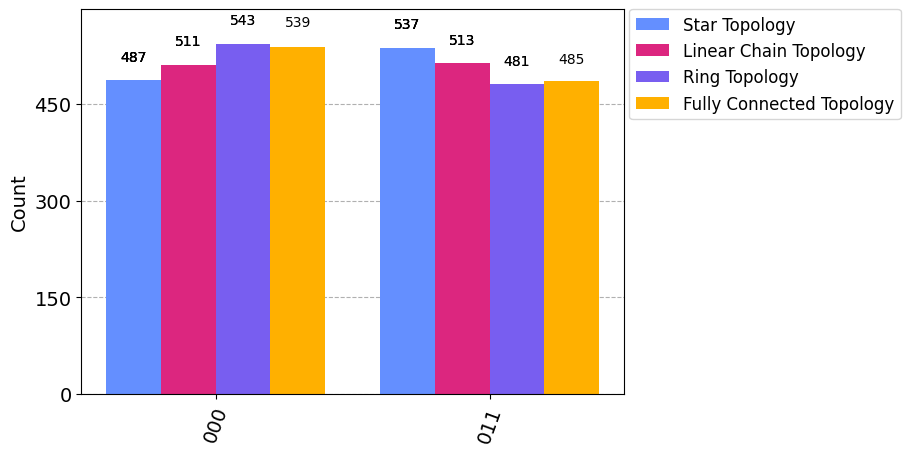

In [5]:
from qiskit import QuantumCircuit, transpile, Aer, execute, QuantumRegister
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout, CouplingMap
import matplotlib.pyplot as plt

%matplotlib inline

# Function to create a quantum circuit with multi-qubit operations
def create_test_circuit(qr):
    qc = QuantumCircuit(qr)
    qc.h(qr[0])
    qc.cx(qr[0], qr[1])  
    qc.cx(qr[1], qr[2])  
    qc.cx(qr[0], qr[2])  
    qc.measure_all()
    return qc

# Function to dynamically switch topology and transpile the circuit
def dynamic_topology_switch(circuit, topology, qr):
    if topology == 'star':
        coupling_map = CouplingMap([[0, 1], [0, 2]])
    elif topology == 'linear':
        coupling_map = CouplingMap([[0, 1], [1, 2]])
    elif topology == 'ring':
        coupling_map = CouplingMap([[0, 1], [1, 2], [2, 0]])
    elif topology == 'fully_connected':
        coupling_map = CouplingMap([[0, 1], [0, 2], [1, 2]])
    else:
        raise ValueError("Unsupported topology")
    
    layout = Layout({qr[0]: 0, qr[1]: 1, qr[2]: 2})
    return transpile(circuit, backend=AerSimulator(), coupling_map=coupling_map, initial_layout=layout)

qr = QuantumRegister(3, 'q')
qc = create_test_circuit(qr)

simulator = AerSimulator() #to simulate

# Different Topology Function 
def run_topology_experiment(qc, topology_name, qr):
    qc_topology = dynamic_topology_switch(qc, topology_name, qr)
    result = execute(qc_topology, simulator).result()
    counts = result.get_counts()
    return qc_topology, counts

# Run experiment for different topologies
qc_star, counts_star = run_topology_experiment(qc, 'star', qr)
qc_linear, counts_linear = run_topology_experiment(qc, 'linear', qr)
qc_ring, counts_ring = run_topology_experiment(qc, 'ring', qr)
qc_fully_connected, counts_fully_connected = run_topology_experiment(qc, 'fully_connected', qr)

# Print transpiled circuits 
print(qc_star)
print("\nCircuit with Linear Chain Topology:")
print(qc_linear)
print("\nCircuit with Ring Topology:")
print(qc_ring)
print("\nCircuit with Fully Connected Topology:")
print(qc_fully_connected)

# Visualize 
plot_histogram([counts_star, counts_linear, counts_ring, counts_fully_connected], 
               legend=['Star Topology', 'Linear Chain Topology', 'Ring Topology', 'Fully Connected Topology'])

# Additional analysis print statements
print("\nDepth of Circuit with Star Topology:", qc_star.depth())
print("Depth of Circuit with Linear Chain Topology:", qc_linear.depth())
print("Depth of Circuit with Ring Topology:", qc_ring.depth())
print("Depth of Circuit with Fully Connected Topology:", qc_fully_connected.depth())

print("\nGate counts for Star Topology:", qc_star.count_ops())
print("Gate counts for Linear Chain Topology:", qc_linear.count_ops())
print("Gate counts for Ring Topology:", qc_ring.count_ops())
print("Gate counts for Fully Connected Topology:", qc_fully_connected.count_ops())
